In [14]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации.
# 4. Вывести результат

Генерация #1
Генерация последовательности из 10 символов...
Сгенерировано: , + 8 X ( w 6 6 h t
Символы без пробелов: [',', '+', '8', 'X', '(', 'w', '6', '6', 'h', 't']


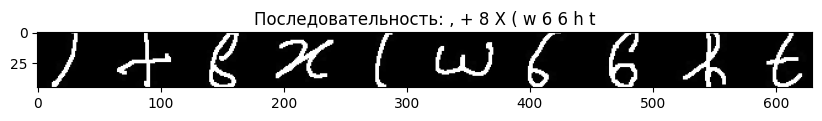

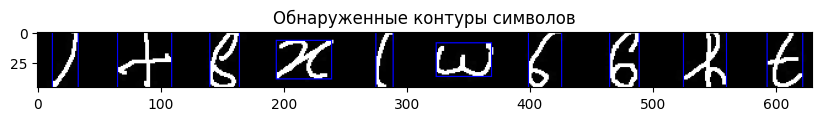

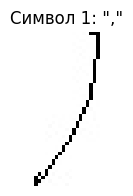

Символ 1: ',' 


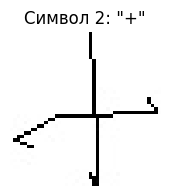

Символ 2: '+' 


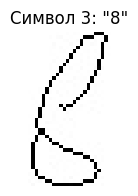

Символ 3: '8' 


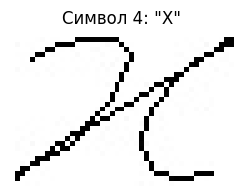

Символ 4: 'X' 


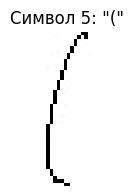

Символ 5: '(' 


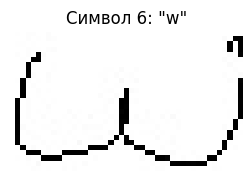

Символ 6: 'w' 


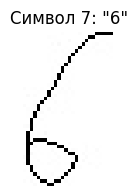

Символ 7: '6' 


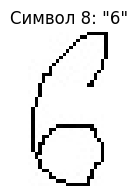

Символ 8: '6' 


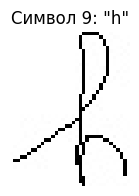

Символ 9: 'h' 


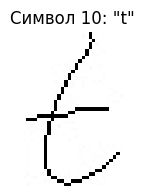

Символ 10: 't' 
Итог: сегментировано 10 символов
Генерация #2
Генерация последовательности из 10 символов...
Сгенерировано: 2 6 6 3 5 t 2 t - 4
Символы без пробелов: ['2', '6', '6', '3', '5', 't', '2', 't', '-', '4']


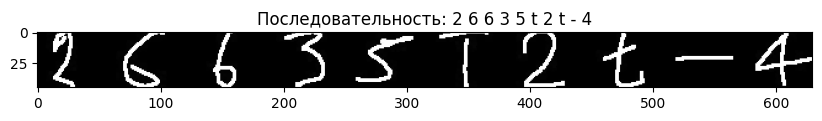

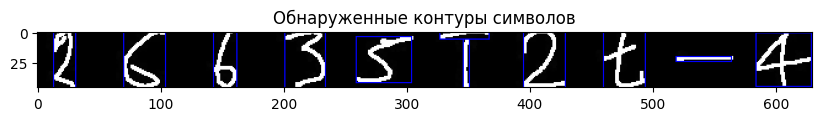

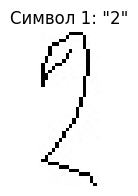

Символ 1: '2' 


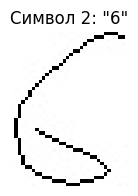

Символ 2: '6' 


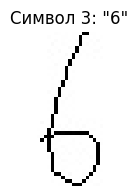

Символ 3: '6' 


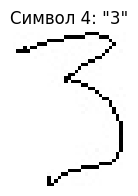

Символ 4: '3' 


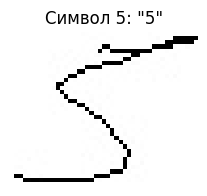

Символ 5: '5' 


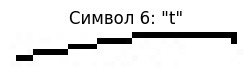

Символ 6: 't' 


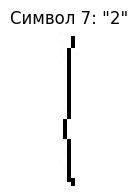

Символ 7: '2' 


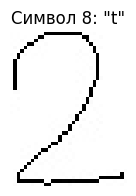

Символ 8: 't' 


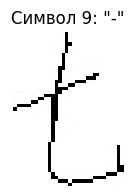

Символ 9: '-' 


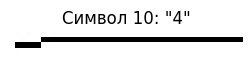

Символ 10: '4' 


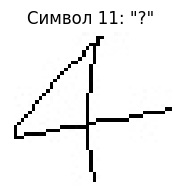

Символ 11: '?' 
Итог: сегментировано 11 символов

Генерация 1:
  Изображение: (45, 630)
  Метки: 10
  Сегментировано символов: 10

Генерация 2:
  Изображение: (45, 630)
  Метки: 10
  Сегментировано символов: 11


In [15]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

class HandwrittenSymbolsGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.symbols_data = {}
        self._load_symbols()

    def _load_symbols(self):
        folders = [f for f in os.listdir(self.data_path)
                   if os.path.isdir(os.path.join(self.data_path, f))]

        total_images = 0
        for folder in folders:
            folder_path = os.path.join(self.data_path, folder)
            images = []

            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    file_path = os.path.join(folder_path, filename)
                    images.append(file_path)

            self.symbols_data[folder] = images
            total_images += len(images)

    def generate_sequence(self, length=10):
        symbols = list(self.symbols_data.keys())
        sequence_images = []
        labels = []

        print(f"Генерация последовательности из {length} символов...")

        for i in range(length):
            symbol = random.choice(symbols)
            image_path = random.choice(self.symbols_data[symbol])
            image = cv2.imread(image_path)
            if image is not None:
                sequence_images.append(image)
                labels.append(symbol)

        sequence_image = self.create_sequence_image(sequence_images)

        print(f"Сгенерировано: {' '.join(labels)}")

        return {
            'sequence_images': sequence_images,
            'sequence_image': sequence_image,
            'labels': labels,
            'sequence_text': ''.join(labels),
            'length': length
        }

    def generate_multiple_sequences(self, num_sequences=5, length=10):
        sequences = []
        for i in range(num_sequences):
            print(f"\n--- Последовательность {i + 1} ---")
            seq_data = self.generate_sequence(length)
            sequences.append(seq_data)
        return sequences

    def create_sequence_image(self, images, spacing=20):
        processed_images = []
        for img in images:
            if len(img.shape) == 3:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                processed_images.append(gray_img)
            else:
                processed_images.append(img)

        total_width = sum(img.shape[1] for img in processed_images) + spacing * (len(processed_images) - 1)
        max_height = max(img.shape[0] for img in processed_images)

        sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

        x_offset = 0
        for img in processed_images:
            h, w = img.shape[:2]
            y_offset = (max_height - h) // 2
            sequence_img[y_offset:y_offset + h, x_offset:x_offset + w] = img
            x_offset += w + spacing

        return sequence_img

    def display_sequence(self, sequence_data, title="Сгенерированная последовательность"):
        plt.figure(figsize=(12, 3))
        plt.imshow(sequence_data['sequence_image'], cmap='gray')
        plt.title(f"{title}: {sequence_data['sequence_text']}")
        plt.show()


DATA_PATH = "./data"
generator = HandwrittenSymbolsGenerator(DATA_PATH)

class SequenceSegmenter:
    def segment_sequence(self, sequence_image, original_labels):
        non_space_labels = [label for label in original_labels if label != ' ']
        print(f"Символы без пробелов: {non_space_labels}")

        img_gray = sequence_image
        kernel = np.ones((3, 3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)

        base_size = img_gray.shape[0], img_gray.shape[1]
        base = np.zeros(base_size, dtype=np.uint8)
        base[0:img_gray.shape[0], 0:img_gray.shape[1]] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

        plt.figure(figsize=(10, 3))
        plt.imshow(base)
        plt.title(f'Последовательность: {" ".join(original_labels)}')
        plt.show()

        ret, thresh = cv2.threshold(base, 127, 255, 0)
        thresh = np.uint8(thresh)
        contours, h = cv2.findContours(thresh[:, :, 0], cv2.RETR_EXTERNAL, 2)

        contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
        crops = []

        img_with_boxes = base.copy()

        for i in range(len(contours_sorted)):
            cnt = contours_sorted[i]
            x, y, w, h = cv2.boundingRect(cnt)
            while (w > 45):
                w -= 1
            if w * h > 50:
                cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 1)
                crops.append([x, y, w, h])

        plt.figure(figsize=(10, 3))
        plt.imshow(img_with_boxes)
        plt.title('Обнаруженные контуры символов')
        plt.show()

        sequence_symbols = []
        for i in range(len(crops)):
            x, y, w, h = crops[i]

            img_crop = sequence_image[y:y + h, x:x + w]

            if i < len(non_space_labels):
                symbol_label = non_space_labels[i]
            else:
                symbol_label = "?"

            plt.figure(figsize=(3, 2))
            plt.imshow(img_crop, cmap="gray")
            plt.title(f'Символ {i + 1}: "{symbol_label}"')
            plt.axis('off')
            plt.show()

            sequence_symbols.append((symbol_label, img_crop))
            print(f"Символ {i + 1}: '{symbol_label}' ")

        return sequence_symbols


all_sequence_data = []
all_segmented_symbols = []

for i in range(2):
    print(f"Генерация #{i+1}")

    sequence_data = generator.generate_sequence(length=10)
    sequence_image = sequence_data['sequence_image']
    labels = sequence_data['labels']

    segmenter = SequenceSegmenter()
    segmented_symbols = segmenter.segment_sequence(sequence_image, labels)

    all_sequence_data.append({
        'sequence_image': sequence_image,
        'labels': labels,
        'segmented_symbols': segmented_symbols
    })
    all_segmented_symbols.append(segmented_symbols)

    print(f"Итог: сегментировано {len(segmented_symbols)} символов")


for i, data in enumerate(all_sequence_data, 1):
    print(f"\nГенерация {i}:")
    print(f"  Изображение: {data['sequence_image'].shape}")
    print(f"  Метки: {len(data['labels'])}")
    print(f"  Сегментировано символов: {len(data['segmented_symbols'])}")

## Тренировка модели kNN

In [16]:
def center_in_45(image, target_size=45):
    h, w = image.shape

    squared = np.zeros((target_size, target_size), dtype=np.uint8)

    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2

    squared[y_offset:y_offset + h, x_offset:x_offset + w] = image
    return squared


def load_training_data(data_path, symbols, train_size=0.8):
    X_train, y_train = [], []

    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)

        images = [f for f in os.listdir(symbol_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images.sort()

        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        mapped_symbol = symbol

        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.bitwise_not(img)
                img_resized = center_in_45(img)
                X_train.append(img_resized.flatten())
                y_train.append(mapped_symbol)

    return np.array(X_train), np.array(y_train)


symbols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'times', 't', 'X', 'y', 'w', 'h', '(', ')', ',']
X_train, y_train = load_training_data(DATA_PATH, symbols, 0.8)
print(f"Обучающая выборка: {len(X_train)} изображений")

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
print("Модель kNN с k=1 обучена")

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
print("Модель kNN с k=3 обучена")

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
print("Модель kNN с k=5 обучена")

knn7 = KNeighborsClassifier(n_neighbors=7)
knn7.fit(X_train, y_train)
print("Модель kNN с k=7 обучена")

print("Все модели обучены")

Обучающая выборка: 180225 изображений
Модель kNN с k=1 обучена
Модель kNN с k=3 обучена
Модель kNN с k=5 обучена
Модель kNN с k=7 обучена
Все модели обучены


ПОСЛЕДОВАТЕЛЬНОСТЬ #1
Генерация последовательности из 10 символов...
Сгенерировано: ) 3 - - , 5 , 1 2 times
Символы без пробелов: [')', '3', '-', '-', ',', '5', ',', '1', '2', 'times']


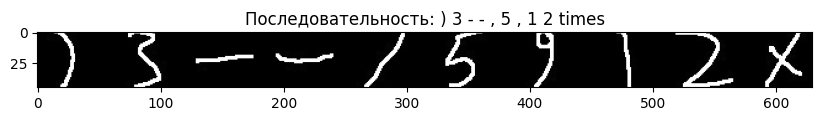

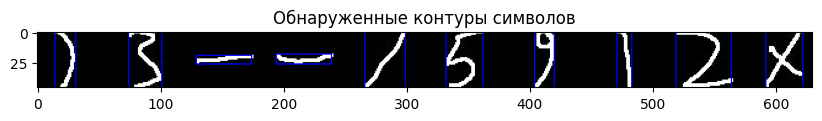

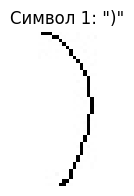

Символ 1: ')' 


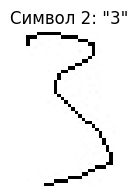

Символ 2: '3' 


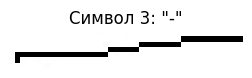

Символ 3: '-' 


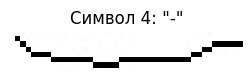

Символ 4: '-' 


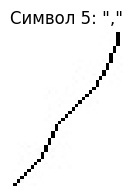

Символ 5: ',' 


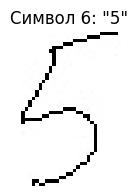

Символ 6: '5' 


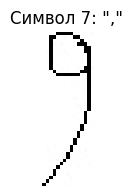

Символ 7: ',' 


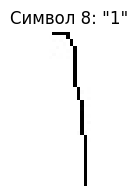

Символ 8: '1' 


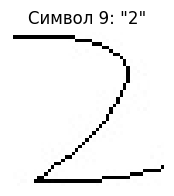

Символ 9: '2' 


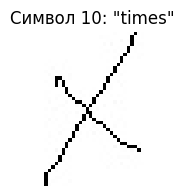

Символ 10: 'times' 
Оригинальный текст: ')3--,5,12times'
Сегментировано 10 символов

knn1 (k=1):
  Предсказано: ')3--,5,12times'
  Точность: 1.00 (14/14)

knn3 (k=3):
  Предсказано: ')3--,5,12times'
  Точность: 1.00 (14/14)

knn5 (k=5):
  Предсказано: ')3--,5,12times'
  Точность: 1.00 (14/14)

knn7 (k=7):
  Предсказано: ')3--,5)12times'
  Точность: 0.93 (13/14)
    Ошибка в позиции 7: ',' → ')'
ПОСЛЕДОВАТЕЛЬНОСТЬ #2
Генерация последовательности из 10 символов...
Сгенерировано: w 6 , 4 t ( 4 3 X +
Символы без пробелов: ['w', '6', ',', '4', 't', '(', '4', '3', 'X', '+']


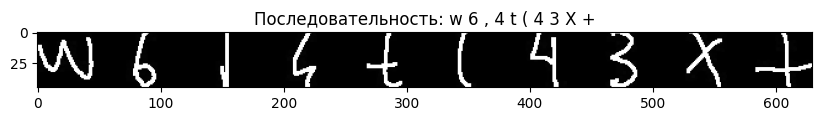

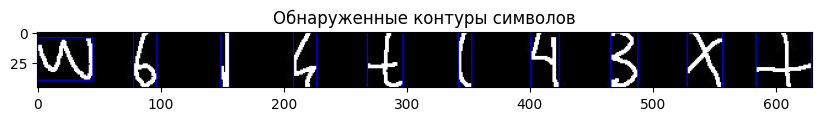

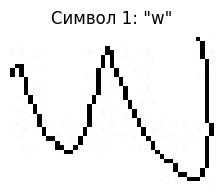

Символ 1: 'w' 


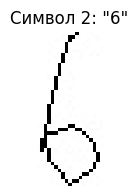

Символ 2: '6' 


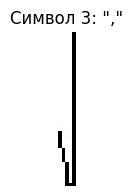

Символ 3: ',' 


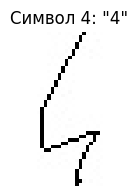

Символ 4: '4' 


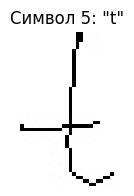

Символ 5: 't' 


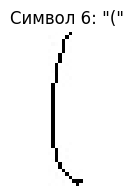

Символ 6: '(' 


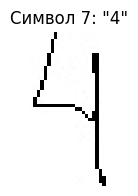

Символ 7: '4' 


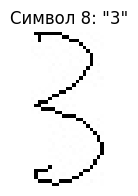

Символ 8: '3' 


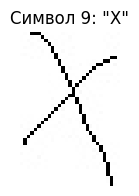

Символ 9: 'X' 


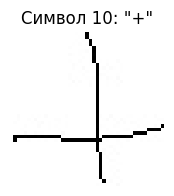

Символ 10: '+' 
Оригинальный текст: 'w6,4t(43X+'
Сегментировано 10 символов

knn1 (k=1):
  Предсказано: 'w6,4t(43X+'
  Точность: 1.00 (10/10)

knn3 (k=3):
  Предсказано: 'w6,4t(43X+'
  Точность: 1.00 (10/10)

knn5 (k=5):
  Предсказано: 'w614t(43)+'
  Точность: 0.80 (8/10)
    Ошибка в позиции 3: ',' → '1'
    Ошибка в позиции 9: 'X' → ')'

knn7 (k=7):
  Предсказано: '((1(+(43)+'
  Точность: 0.40 (4/10)
    Ошибка в позиции 1: 'w' → '('
    Ошибка в позиции 2: '6' → '('
    Ошибка в позиции 3: ',' → '1'
    Ошибка в позиции 4: '4' → '('
    Ошибка в позиции 5: 't' → '+'
    Ошибка в позиции 9: 'X' → ')'
ПОСЛЕДОВАТЕЛЬНОСТЬ #3
Генерация последовательности из 10 символов...
Сгенерировано: 8 - 8 h 9 7 ( 4 4 times
Символы без пробелов: ['8', '-', '8', 'h', '9', '7', '(', '4', '4', 'times']


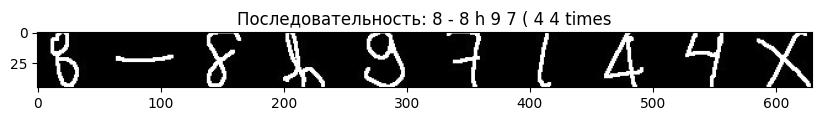

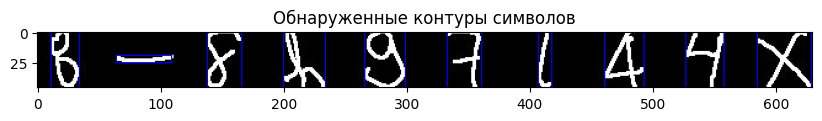

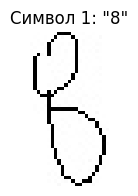

Символ 1: '8' 


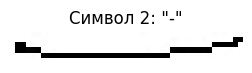

Символ 2: '-' 


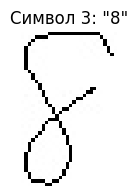

Символ 3: '8' 


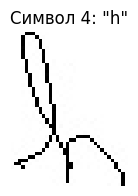

Символ 4: 'h' 


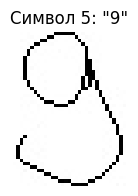

Символ 5: '9' 


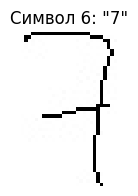

Символ 6: '7' 


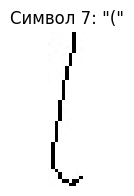

Символ 7: '(' 


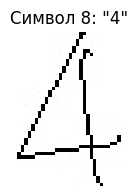

Символ 8: '4' 


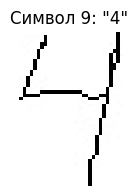

Символ 9: '4' 


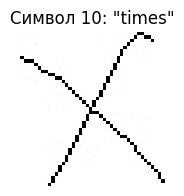

Символ 10: 'times' 
Оригинальный текст: '8-8h97(44times'
Сегментировано 10 символов

knn1 (k=1):
  Предсказано: '8-8h97(44times'
  Точность: 1.00 (14/14)

knn3 (k=3):
  Предсказано: '8-Xh97(44times'
  Точность: 0.93 (13/14)
    Ошибка в позиции 3: '8' → 'X'

knn5 (k=5):
  Предсказано: '8-Xh97(44times'
  Точность: 0.93 (13/14)
    Ошибка в позиции 3: '8' → 'X'

knn7 (k=7):
  Предсказано: '8-X(97(41times'
  Точность: 0.79 (11/14)
    Ошибка в позиции 3: '8' → 'X'
    Ошибка в позиции 4: 'h' → '('
    Ошибка в позиции 9: '4' → '1'
ПОСЛЕДОВАТЕЛЬНОСТЬ #4
Генерация последовательности из 10 символов...
Сгенерировано: 9 6 ( + 8 2 y 5 , 2
Символы без пробелов: ['9', '6', '(', '+', '8', '2', 'y', '5', ',', '2']


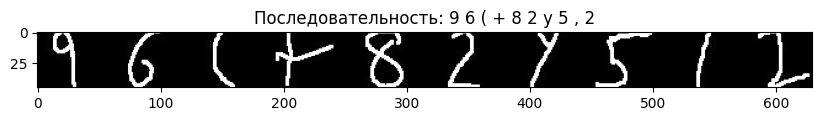

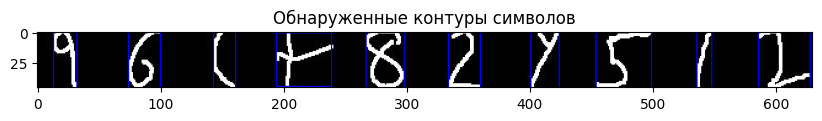

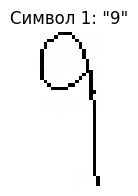

Символ 1: '9' 


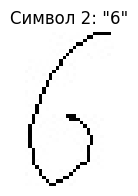

Символ 2: '6' 


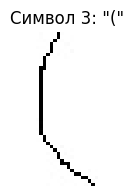

Символ 3: '(' 


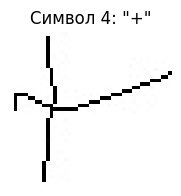

Символ 4: '+' 


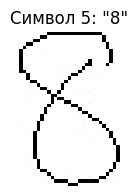

Символ 5: '8' 


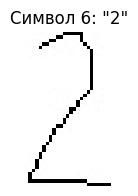

Символ 6: '2' 


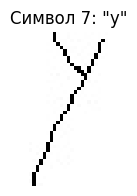

Символ 7: 'y' 


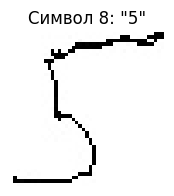

Символ 8: '5' 


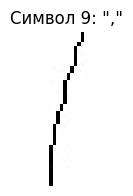

Символ 9: ',' 


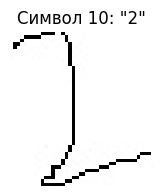

Символ 10: '2' 
Оригинальный текст: '96(+82y5,2'
Сегментировано 10 символов

knn1 (k=1):
  Предсказано: '96(t82y5,2'
  Точность: 0.90 (9/10)
    Ошибка в позиции 4: '+' → 't'

knn3 (k=3):
  Предсказано: '96(t(2y5(('
  Точность: 0.60 (6/10)
    Ошибка в позиции 4: '+' → 't'
    Ошибка в позиции 5: '8' → '('
    Ошибка в позиции 9: ',' → '('
    Ошибка в позиции 10: '2' → '('

knn5 (k=5):
  Предсказано: '16(t(2y5(('
  Точность: 0.50 (5/10)
    Ошибка в позиции 1: '9' → '1'
    Ошибка в позиции 4: '+' → 't'
    Ошибка в позиции 5: '8' → '('
    Ошибка в позиции 9: ',' → '('
    Ошибка в позиции 10: '2' → '('

knn7 (k=7):
  Предсказано: ')((-(2y5(('
  Точность: 0.40 (4/10)
    Ошибка в позиции 1: '9' → ')'
    Ошибка в позиции 2: '6' → '('
    Ошибка в позиции 4: '+' → '-'
    Ошибка в позиции 5: '8' → '('
    Ошибка в позиции 9: ',' → '('
    Ошибка в позиции 10: '2' → '('
ПОСЛЕДОВАТЕЛЬНОСТЬ #5
Генерация последовательности из 10 символов...
Сгенерировано: 1 6 y t times ( ( 1 h -
Символы б

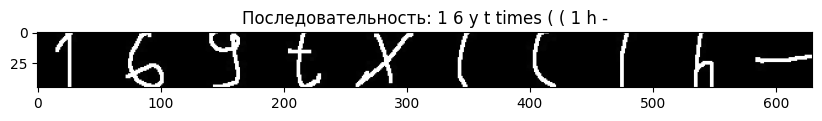

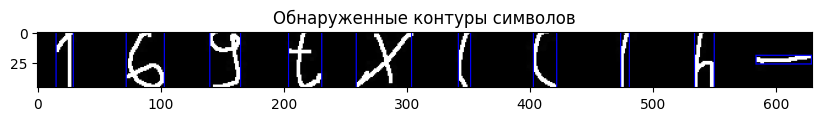

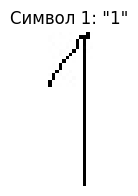

Символ 1: '1' 


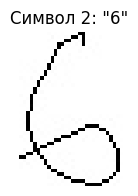

Символ 2: '6' 


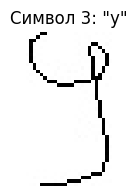

Символ 3: 'y' 


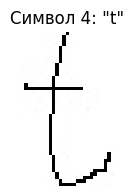

Символ 4: 't' 


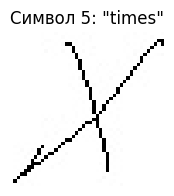

Символ 5: 'times' 


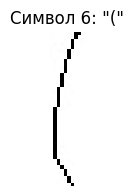

Символ 6: '(' 


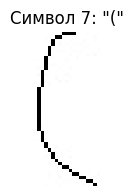

Символ 7: '(' 


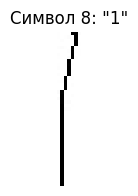

Символ 8: '1' 


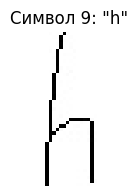

Символ 9: 'h' 


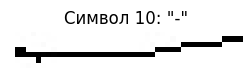

Символ 10: '-' 
Оригинальный текст: '16yttimes((1h-'
Сегментировано 10 символов

knn1 (k=1):
  Предсказано: '16yt)((1h-'
  Точность: 0.29 (4/14)
    Ошибка в позиции 5: 't' → ')'
    Ошибка в позиции 6: 'i' → '('
    Ошибка в позиции 7: 'm' → '('
    Ошибка в позиции 8: 'e' → '1'
    Ошибка в позиции 9: 's' → 'h'
    Ошибка в позиции 10: '(' → '-'

knn3 (k=3):
  Предсказано: '16yt)((1h-'
  Точность: 0.29 (4/14)
    Ошибка в позиции 5: 't' → ')'
    Ошибка в позиции 6: 'i' → '('
    Ошибка в позиции 7: 'm' → '('
    Ошибка в позиции 8: 'e' → '1'
    Ошибка в позиции 9: 's' → 'h'
    Ошибка в позиции 10: '(' → '-'

knn5 (k=5):
  Предсказано: '16yt)((1h-'
  Точность: 0.29 (4/14)
    Ошибка в позиции 5: 't' → ')'
    Ошибка в позиции 6: 'i' → '('
    Ошибка в позиции 7: 'm' → '('
    Ошибка в позиции 8: 'e' → '1'
    Ошибка в позиции 9: 's' → 'h'
    Ошибка в позиции 10: '(' → '-'

knn7 (k=7):
  Предсказано: '1()t1((1h-'
  Точность: 0.14 (2/14)
    Ошибка в позиции 2: '6' → '('
    Ошибка 

In [17]:
import numpy as np
import cv2

def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

models = {
    'knn1 (k=1)': knn1,
    'knn3 (k=3)': knn3,
    'knn5 (k=5)': knn5,
    'knn7 (k=7)': knn7
}

all_results = []
num_sequences = 5

for seq_num in range(num_sequences):
    print(f"ПОСЛЕДОВАТЕЛЬНОСТЬ #{seq_num + 1}")
    print(f"{'='*60}")

    sequence_data = generator.generate_sequence(length=10)
    original_labels = sequence_data['labels']
    sequence_image = sequence_data['sequence_image']
    original_text_str = sequence_data['sequence_text']

    segmenter = SequenceSegmenter()
    symbols_data = segmenter.segment_sequence(sequence_image, original_labels)

    resized_symbols = []
    for true_label, symbol_img in symbols_data:
        processed_img = cv2.bitwise_not(symbol_img)
        resized_img = center_in_45(processed_img)
        resized_symbols.append((true_label, resized_img))
    symbols_data = resized_symbols

    print(f"Оригинальный текст: '{original_text_str}'")
    print(f"Сегментировано {len(symbols_data)} символов")
    seq_results = {'sequence_text': original_text_str, 'models': {}}

    for model_name, model in models.items():
        predicted_symbols = []

        for j, (true_label, symbol_img) in enumerate(symbols_data):
            img_flat = symbol_img.flatten()
            predicted_char = model.predict([img_flat])[0]
            predicted_symbols.append(predicted_char)

        predicted_text = ''.join(predicted_symbols)

        correct_chars = sum(1 for orig, pred in zip(original_text_str, predicted_text) if orig == pred)
        total_chars = len(original_text_str)
        accuracy = correct_chars / total_chars if total_chars > 0 else 0

        seq_results['models'][model_name] = {
            'predicted_text': predicted_text,
            'accuracy': accuracy,
            'correct_chars': correct_chars,
            'total_chars': total_chars
        }

        print(f"\n{model_name}:")
        print(f"  Предсказано: '{predicted_text}'")
        print(f"  Точность: {accuracy:.2f} ({correct_chars}/{total_chars})")

        if original_text_str != predicted_text:
            for idx, (orig_char, pred_char) in enumerate(zip(original_text_str, predicted_text)):
                if orig_char != pred_char:
                    print(f"    Ошибка в позиции {idx+1}: '{orig_char}' → '{pred_char}'")

    all_results.append(seq_results)

print(f"\n{'='*80}")
print("ИТОГОВАЯ СТАТИСТИКА ПО ПОСЛЕДОВАТЕЛЬНОСТЯМ")
print(f"{'='*80}")

model_stats = {model_name: {'accuracies': [], 'total_correct': 0, 'total_chars': 0}
               for model_name in models.keys()}

for seq_num, seq_result in enumerate(all_results, 1):
    print(f"\nПоследовательность #{seq_num}: '{seq_result['sequence_text']}'")
    for model_name, model_result in seq_result['models'].items():
        model_stats[model_name]['accuracies'].append(model_result['accuracy'])
        model_stats[model_name]['total_correct'] += model_result['correct_chars']
        model_stats[model_name]['total_chars'] += model_result['total_chars']

        print(f"  {model_name}: {model_result['accuracy']:.2f} "
              f"('{model_result['predicted_text']}')")

print(f"\n{'='*80}")
print("СРЕДНЯЯ ТОЧНОСТЬ ПО ВСЕМ ПОСЛЕДОВАТЕЛЬНОСТЯМ:")
print(f"{'='*80}")

average_accuracies = []
for model_name, stats in model_stats.items():
    avg_accuracy = np.mean(stats['accuracies'])
    total_accuracy = stats['total_correct'] / stats['total_chars']
    average_accuracies.append((model_name, avg_accuracy, total_accuracy, stats))

# Сортируем по убыванию средней точности
average_accuracies.sort(key=lambda x: x[1], reverse=True)

print(f"{'Модель':<15} | {'Средняя точность':<18} | {'Общая точность':<16} | {'Правильно'}")
print(f"{'-'*70}")

for model_name, avg_accuracy, total_accuracy, stats in average_accuracies:
    print(f"{model_name:<15} | {avg_accuracy*100:6.2f}%           | {total_accuracy*100:6.2f}%        | "
          f"{stats['total_correct']}/{stats['total_chars']}")

print(f"\nЛучшая модель по средней точности: '{average_accuracies[0][0]}' "
      f"({average_accuracies[0][1]*100:.2f}%)")